# Section 1:Read form CSV files

In [ ]:
import os, glob, textwrap, itertools
import pandas as pd
import numpy as np

ROOT = "digital_twin/data/ohio/2018/train_cleaned"

assert os.path.exists(ROOT), "aftdb root not found—check your path."

records = sorted([os.path.splitext(os.path.basename(p))[0]
                  for p in glob.glob(os.path.join(ROOT, "*.csv"))])
print("Found", len(records), "records. First 10:", records[:6])

Found 6 records. First 10: ['559-ws-training', '563-ws-training', '570-ws-training', '575-ws-training', '588-ws-training', '591-ws-training']


In [ ]:
data_path = "digital_twin/data/ohio/2018/train_cleaned"
csv_files = sorted(glob.glob(os.path.join(data_path, "*.csv")))
assert csv_files, "No CSV files found."

dfs = []
for f in csv_files:
    tmp = pd.read_csv(f)
    tmp.columns = [c.strip() for c in tmp.columns]
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"].astype(str).str.strip(),
                                      errors="coerce", infer_datetime_format=True)
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

/tmp/ipykernel_2751/419851657.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tmp["timestamp"] = pd.to_datetime(tmp["timestamp"].astype(str).str.strip(),
/tmp/ipykernel_2751/419851657.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tmp["timestamp"] = pd.to_datetime(tmp["timestamp"].astype(str).str.strip(),
/tmp/ipykernel_2751/419851657.py:9: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tmp["timestamp"] = pd.to_datetime(tmp[

# Section 3: preprocessing and MODEL

In [ ]:
# =========================================
# Glucose LSTM — with proper glucose cleaning
# =========================================
data_path = "digital_twin/data/ohio/2018/train_cleaned" 
csv_files = sorted(glob.glob(os.path.join(data_path, "*.csv")))
assert csv_files, "No CSV files found."

dfs = []
for f in csv_files:
    tmp = pd.read_csv(f)
    tmp.columns = [c.strip() for c in tmp.columns]            
    tmp["timestamp"] = pd.to_datetime(
        tmp["timestamp"].astype(str).str.strip(),
        errors="coerce", infer_datetime_format=True
    )
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

# ------------------------- 2) Select features you want ----------------------
keep = ["timestamp", "bolus_dose", "exercise_intensity", "basis_sleep_binary", "glucose_level", "meal_carbs"]
missing = [c for c in keep if c not in df.columns]
assert not missing, f"Missing expected columns: {missing}"

data = df[keep].copy()
data.set_index("timestamp", inplace=True)
assert isinstance(data.index, pd.DatetimeIndex), "Index must be DatetimeIndex."

# ------------------------- 3) Proper glucose cleaning -----------------------
for c in data.columns:
    data[c] = pd.to_numeric(data[c], errors="coerce")

g = data["glucose_level"].copy()
g[g <= 0] = np.nan                  
# g[g < 40] = np.nan               
g = g.interpolate(method="time", limit_direction="both")
g = g.ffill().bfill()
g = g.clip(lower=40, upper=400)     
data["glucose_level"] = g

for c in data.columns:
    if c != "glucose_level":
        data[c] = data[c].fillna(0.0)

print("Sanity — NaNs in glucose:", data["glucose_level"].isna().sum())
print("Sanity — Zeros in glucose:", (data["glucose_level"] == 0).sum())
print("Sanity — Glucose min/max:", float(data["glucose_level"].min()), float(data["glucose_level"].max()))

/tmp/ipykernel_2751/1419581984.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tmp["timestamp"] = pd.to_datetime(
/tmp/ipykernel_2751/1419581984.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tmp["timestamp"] = pd.to_datetime(
/tmp/ipykernel_2751/1419581984.py:12: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tmp["timestamp"] = pd.to_datetime(
/tmp/ipykernel_2751/1419581984.py:12: UserWarning: The argument 'infer_datetime

Sanity — NaNs in glucose: 0
Sanity — Zeros in glucose: 0
Sanity — Glucose min/max: 40.0 400.0


/tmp/ipykernel_2751/1419581984.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tmp["timestamp"] = pd.to_datetime(
/tmp/ipykernel_2751/1419581984.py:12: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tmp["timestamp"] = pd.to_datetime(


In [4]:
# ------------------------- 5) Train/val/test split --------------------------
n = len(data)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)
train_df = data.iloc[:train_end].copy()
val_df   = data.iloc[train_end:val_end].copy()
test_df  = data.iloc[val_end:].copy()

# ------------------------- 6) Scale (fit on train only) ---------------------
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df.values)

train_scaled = scaler.transform(train_df.values)
val_scaled   = scaler.transform(val_df.values)
test_scaled  = scaler.transform(test_df.values)

feature_names = list(data.columns)
glucose_idx = feature_names.index("glucose_level")

# ------------------------- 7) Make sequences for LSTM -----------------------
def make_sequences(arr, n_steps, target_col_idx):
    X, y = [], []
    for i in range(len(arr) - n_steps):
        X.append(arr[i:i+n_steps, :])
        y.append(arr[i+n_steps, target_col_idx])
    return np.array(X), np.array(y)

n_steps = 12  # ~1h lookback for 5-min data
X_train, y_train = make_sequences(train_scaled, n_steps, glucose_idx)
X_val,   y_val   = make_sequences(val_scaled,   n_steps, glucose_idx)
X_test,  y_test  = make_sequences(test_scaled,  n_steps, glucose_idx)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ------------------------- 8) PyTorch model & training ----------------------
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def to_tensor(x): return torch.from_numpy(x.astype(np.float32))

train_loader = DataLoader(TensorDataset(to_tensor(X_train), to_tensor(y_train).unsqueeze(-1)), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(to_tensor(X_val),   to_tensor(y_val).unsqueeze(-1)),   batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(to_tensor(X_test),  to_tensor(y_test).unsqueeze(-1)),  batch_size=64, shuffle=False)

class GlucoseLSTM(nn.Module):
    def __init__(self, input_size, h1=64, h2=32, p=0.2):
        super().__init__()
        self.l1 = nn.LSTM(input_size=input_size, hidden_size=h1, batch_first=True)
        self.do = nn.Dropout(p)
        self.l2 = nn.LSTM(input_size=h1, hidden_size=h2, batch_first=True)
        self.fc = nn.Linear(h2, 1)
    def forward(self, x):
        x,_ = self.l1(x); x = self.do(x); x,_ = self.l2(x)
        return self.fc(x[:, -1, :])

model = GlucoseLSTM(input_size=X_train.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val = float("inf"); patience=5; pat=0; best_state=None
for ep in range(1, 26):
    model.train(); tr=0.0
    for xb,yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        tr += loss.item()*xb.size(0)
    tr /= len(train_loader.dataset)

    model.eval(); va=0.0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            va += criterion(model(xb), yb).item()*xb.size(0)
    va /= len(val_loader.dataset)
    print(f"Epoch {ep:02d} | Train MSE {tr:.5f} | Val MSE {va:.5f}")

    if va < best_val - 1e-6:
        best_val = va; best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}; pat=0
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping."); break

if best_state is not None: model.load_state_dict(best_state)
model.eval().to(device)

# ------------------------- 9) Predict & inverse-scale -----------------------
def torch_predict(loader):
    outs=[]
    with torch.no_grad():
        for xb,_ in loader:
            outs.append(model(xb.to(device)).cpu().numpy())
    return np.vstack(outs).ravel()

y_pred_train = torch_predict(train_loader)
y_pred_val   = torch_predict(val_loader)
y_pred_test  = torch_predict(test_loader)

def invert_glucose(y_scaled, scaler, glucose_idx, feature_names):
    tmp = np.zeros((len(y_scaled), len(feature_names)), dtype=np.float32)
    tmp[:, glucose_idx] = y_scaled
    return scaler.inverse_transform(tmp)[:, glucose_idx]

inv_y_train    = invert_glucose(y_train.ravel(),   scaler, glucose_idx, feature_names)
inv_y_val      = invert_glucose(y_val.ravel(),     scaler, glucose_idx, feature_names)
inv_y_test     = invert_glucose(y_test.ravel(),    scaler, glucose_idx, feature_names)
inv_pred_train = invert_glucose(y_pred_train,      scaler, glucose_idx, feature_names)
inv_pred_val   = invert_glucose(y_pred_val,        scaler, glucose_idx, feature_names)
inv_pred_test  = invert_glucose(y_pred_test,       scaler, glucose_idx, feature_names)

print("TRAIN inv glucose min/max:", inv_y_train.min(), inv_y_train.max())
print("TEST  inv glucose min/max:",  inv_y_test.min(),  inv_y_test.max())
assert inv_y_train.min() > 0, "Train glucose has zeros; check preprocessing."
assert inv_y_test.min()  > 0, "Test glucose has zeros; check preprocessing."

# ------------------------- 10) Metrics & plot -------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = lambda a,b: mean_squared_error(a,b,squared=False)
mae  = lambda a,b: mean_absolute_error(a,b)

print(f"Train RMSE {rmse(inv_y_train, inv_pred_train):.2f} | MAE {mae(inv_y_train, inv_pred_train):.2f}")
print(f"Val   RMSE {rmse(inv_y_val,   inv_pred_val):.2f} | MAE {mae(inv_y_val,   inv_pred_val):.2f}")
print(f"Test  RMSE {rmse(inv_y_test,  inv_pred_test):.2f} | MAE {mae(inv_y_test,  inv_pred_test):.2f}")

Shapes: (43541, 12, 5) (9321, 12, 5) (9321, 12, 5)
Using device: cuda
Epoch 01 | Train MSE 0.01270 | Val MSE 0.01383
Epoch 02 | Train MSE 0.00959 | Val MSE 0.01243
Epoch 03 | Train MSE 0.00895 | Val MSE 0.01231
Epoch 04 | Train MSE 0.00882 | Val MSE 0.01268
Epoch 05 | Train MSE 0.00873 | Val MSE 0.01240
Epoch 06 | Train MSE 0.00873 | Val MSE 0.01239
Epoch 07 | Train MSE 0.00863 | Val MSE 0.01230
Epoch 08 | Train MSE 0.00860 | Val MSE 0.01224
Epoch 09 | Train MSE 0.00840 | Val MSE 0.01196
Epoch 10 | Train MSE 0.00797 | Val MSE 0.01188
Epoch 11 | Train MSE 0.00770 | Val MSE 0.01158
Epoch 12 | Train MSE 0.00751 | Val MSE 0.01147
Epoch 13 | Train MSE 0.00727 | Val MSE 0.01088
Epoch 14 | Train MSE 0.00692 | Val MSE 0.01038
Epoch 15 | Train MSE 0.00660 | Val MSE 0.01026
Epoch 16 | Train MSE 0.00633 | Val MSE 0.00997
Epoch 17 | Train MSE 0.00613 | Val MSE 0.00984
Epoch 18 | Train MSE 0.00605 | Val MSE 0.00954
Epoch 19 | Train MSE 0.00594 | Val MSE 0.00958
Epoch 20 | Train MSE 0.00591 | Val MS

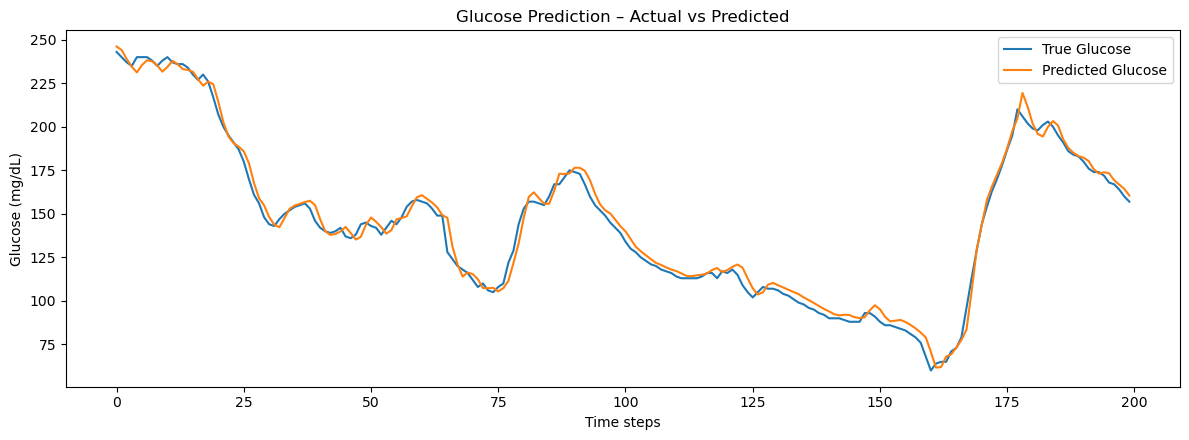

In [5]:
import matplotlib.pyplot as plt
#k = min(400, len(inv_y_test))
k=500
plt.figure(figsize=(12,4.5))
plt.plot(inv_y_test[300:k],  label="True Glucose")
plt.plot(inv_pred_test[300:k], label="Predicted Glucose")
plt.ylabel("Glucose (mg/dL)"); plt.xlabel("Time steps")
plt.title("Glucose Prediction – Actual vs Predicted")
plt.legend(); plt.tight_layout(); plt.show()

# Interactive prediction:
a new user (say in a UI or script) enters their most recent bolus, exercise, sleep status, and glucose readings, and the model predicts the next glucose level.

In [6]:
import torch
def predict_next_glucose(model, scaler, feature_names, glucose_idx, recent_df, n_steps=12, device="cpu"):
    """
    Predict the next glucose value from the most recent data window.
    
    Args:
        model        : trained PyTorch model
        scaler       : fitted MinMaxScaler
        feature_names: list of feature column names (same order as training)
        glucose_idx  : index of 'glucose_level' in feature_names
        recent_df    : pd.DataFrame with the *last n_steps rows* of features
        n_steps      : lookback length used in training
        device       : "cpu" or "cuda"
    Returns:
        next_glucose (float) in mg/dL
    """
    assert len(recent_df) >= n_steps, f"Need at least {n_steps} rows"
    arr = scaler.transform(recent_df.values)
    window = arr[-n_steps:, :]
    x = torch.from_numpy(window.astype(np.float32)).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        y_scaled = model(x).cpu().numpy().ravel()[0]
    tmp = np.zeros((1, len(feature_names)))
    tmp[:, glucose_idx] = y_scaled
    inv = scaler.inverse_transform(tmp)
    return float(inv[0, glucose_idx])

In [7]:
# Take the last n_steps rows from test_df
recent_window = test_df.tail(n_steps)

next_glu = predict_next_glucose(
    model, scaler, feature_names, glucose_idx, recent_window,
    n_steps=n_steps, device=device
)
print("Predicted next glucose:", next_glu, "mg/dL")


Predicted next glucose: 150.24404764175415 mg/dL


In [8]:
predicted_values = []
window = test_df.tail(n_steps) 

for step in range(12):  #12×5min=60min
    next_val = predict_next_glucose(
        model, scaler, feature_names, glucose_idx,
        window, n_steps=n_steps, device=device
    )
    predicted_values.append(next_val)
    next_row = window.iloc[-1].copy()
    next_row["glucose_level"] = next_val
    window = pd.concat([window, next_row.to_frame().T], ignore_index=True)
    window = window.tail(n_steps)  # keep window size constant
for i, val in enumerate(predicted_values):
    print(f"Step {i+1} ({(i+1)*5} min ahead): {val:.2f} mg/dL")


Step 1 (5 min ahead): 150.24 mg/dL
Step 2 (10 min ahead): 137.08 mg/dL
Step 3 (15 min ahead): 140.98 mg/dL
Step 4 (20 min ahead): 141.36 mg/dL
Step 5 (25 min ahead): 140.61 mg/dL
Step 6 (30 min ahead): 144.05 mg/dL
Step 7 (35 min ahead): 143.79 mg/dL
Step 8 (40 min ahead): 145.95 mg/dL
Step 9 (45 min ahead): 147.57 mg/dL
Step 10 (50 min ahead): 149.54 mg/dL
Step 11 (55 min ahead): 152.13 mg/dL
Step 12 (60 min ahead): 155.00 mg/dL


# Section 4:Run meal scenarios (digital twin)

In [9]:
def _tri_kernel(t_min, peak_at=60, total=180):
    """
    Triangular kernel (0..total) peaking at 'peak_at', normalized to sum=1 over its support.
    """
    t = np.asarray(t_min, dtype=float)
    w = np.zeros_like(t)
    rise = (t >= 0) & (t <= peak_at)
    fall = (t > peak_at) & (t <= total)
    w[rise] = (t[rise] / max(peak_at, 1e-6))
    w[fall] = (total - t[fall]) / max(total - peak_at, 1e-6)
    w = np.clip(w, 0, None)
    s = w.sum()
    return w / s if s > 0 else w

def _make_profile(length_steps, at_step, magnitude, kernel_minutes, dt_min):
    """
    Places a kernel-shaped profile (non-negative, sums to 1) starting at 'at_step'
    and scales it so the discrete sum equals 'magnitude'.
    """
    prof = np.zeros(length_steps, dtype=float)
    if at_step is None or magnitude == 0:
        return prof
    grid = np.arange(0, length_steps) * dt_min
    w = _tri_kernel(grid - at_step * dt_min, peak_at=kernel_minutes[0], total=kernel_minutes[1])
    if w.sum() > 0:
        w = w * (magnitude / w.sum())
    return w

# -------------------- hybrid digital-twin simulator --------------------
def simulate_meal_insulin_hybrid(
    model, scaler, df_now, feature_names,
    steps=12, seq_len=36, dt_min=5,
    meal_at_step=None, meal_grams=0.0,
    bolus_at_step=None, bolus_units=0.0,
    # kernels (minutes)
    carb_peak_min=60, carb_total_min=180,
    ins_peak_min=75, ins_total_min=300,
    # physiology:
    ISF_mgdl_per_U=50.0,   # insulin sensitivity factor: ↓ mg/dL per 1 unit insulin
    CR_g_per_U=10.0,       # carb ratio: grams that are counteracted by 1U insulin
    hold_inputs="last",
):
    """
    Hybrid roll-out:
      1) Predict next glucose with the trained model (scaled features, autoregressive).
      2) Convert to mg/dL.
      3) Add a *physiology-informed residual*:
           + carb_effect(t)  (raises glucose)
           - insulin_effect(t) (lowers glucose)
         where area(carb_effect) ≈ (meal_grams/CR)*ISF and area(insulin_effect) ≈ bolus_units*ISF.
      4) Feed the new glucose back as the next-step feature (and also inject raw meal/bolus features).

    Returns a DataFrame with columns:
      'glucose_pred', 'carb_effect', 'insulin_effect', 'carb_profile', 'bolus_profile'
    """
    df_now = df_now.copy()
    for col in feature_names:
        if col not in df_now.columns:
            df_now[col] = 0.0
    df_now = df_now[feature_names]

    F = len(feature_names)
    try:
        glucose_idx = feature_names.index("glucose_level")
    except ValueError:
        raise ValueError("feature_names must include 'glucose_level'")
    try:
        meal_idx = feature_names.index("meal_carbs")
    except ValueError:
        meal_idx = None
    try:
        bolus_idx = feature_names.index("bolus_dose")
    except ValueError:
        bolus_idx = None

    device = next(model.parameters()).device

    arr_scaled = scaler.transform(df_now.values)
    seq = arr_scaled[-seq_len:].copy()
    base_cov_orig = df_now.values[-1, :].astype(np.float32)
    if hold_inputs == "zero":
        base_cov_orig = np.zeros_like(base_cov_orig)
    
    carb_profile_feat  = _make_profile(steps, meal_at_step, meal_grams,
                                       (carb_peak_min, carb_total_min), dt_min)
    bolus_profile_feat = _make_profile(steps, bolus_at_step, bolus_units,
                                       (0.1, dt_min), dt_min)  # near impulse

    # ---------- build PHYSIOLOGICAL EFFECTS in mg/dL ----------
    # Total expected rise from carbs (if no insulin) ~ (grams/CR)*ISF
    total_rise_mgdl = (meal_grams / max(CR_g_per_U, 1e-6)) * ISF_mgdl_per_U
    carb_effect = _make_profile(steps, meal_at_step, total_rise_mgdl,
                                (carb_peak_min, carb_total_min), dt_min)

    # Total expected fall from insulin ~ (units)*ISF
    total_fall_mgdl = bolus_units * ISF_mgdl_per_U
    insulin_effect = _make_profile(steps, bolus_at_step, total_fall_mgdl,
                                   (ins_peak_min, ins_total_min), dt_min)

    preds_mgdl = []
    for step in range(steps):
        #model prediction in scaled space
        x = torch.from_numpy(seq.astype(np.float32)).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            y_scaled = model(x).cpu().numpy().ravel()[0]

        #inverse-scale to mg/dL
        tmp = np.zeros((1, F), dtype=np.float32)
        tmp[:, glucose_idx] = y_scaled
        glu_mgdl = scaler.inverse_transform(tmp)[0, glucose_idx]

        #add physiology-informed residual for this step
        #     carb raises, insulin lowers
        glu_mgdl = glu_mgdl + carb_effect[step] - insulin_effect[step]
        preds_mgdl.append(glu_mgdl)

        #build next feature vector (original space)
        feat_orig = base_cov_orig.copy()
        feat_orig[glucose_idx] = glu_mgdl
        if meal_idx is not None:
            feat_orig[meal_idx] = carb_profile_feat[step]
        if bolus_idx is not None:
            feat_orig[bolus_idx] = bolus_profile_feat[step]

        #scale & roll
        feat_scaled = scaler.transform(feat_orig.reshape(1, -1))[0]
        seq = np.vstack([seq[1:], feat_scaled])

    return pd.DataFrame({
        "glucose_pred":   np.array(preds_mgdl, dtype=float),
        "carb_effect":    carb_effect.astype(float),
        "insulin_effect": insulin_effect.astype(float),
        "carb_profile":   carb_profile_feat.astype(float),
        "bolus_profile":  bolus_profile_feat.astype(float),
    })

# -------------------- quick plotting helper --------------------
def plot_digital_twin(
    baseline_df, *others, labels=None, title="Digital Twin Meal/Insulin Scenarios in one hour"
):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4.4))
    plt.plot(baseline_df["glucose_pred"], label="Baseline")
    if others:
        if labels is None:
            labels = [f"Scenario {i+1}" for i in range(len(others))]
        for df_s, lb in zip(others, labels):
            plt.plot(df_s["glucose_pred"], label=lb)
    plt.title(title)
    plt.ylabel("Glucose (mg/dL)")
    plt.xlabel("Steps (dt)")
    plt.grid(alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


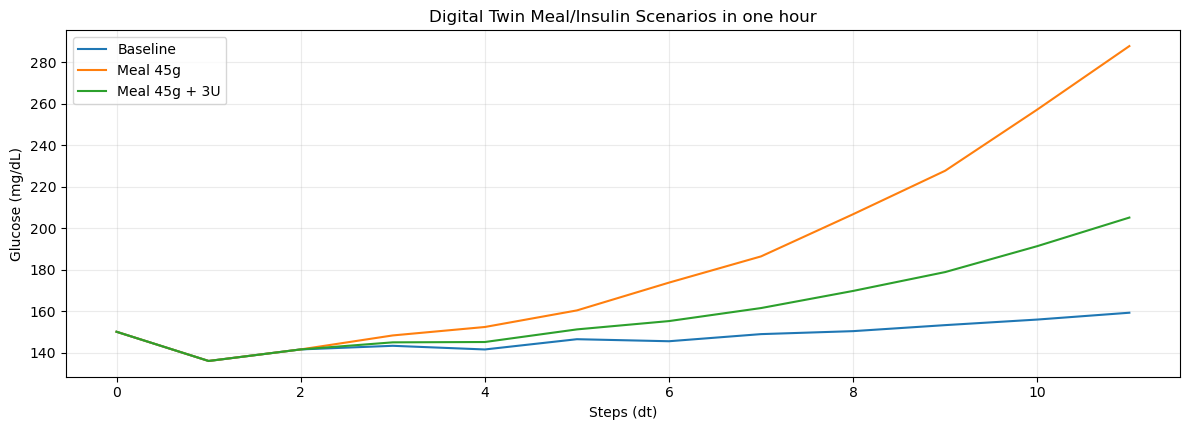

In [10]:
df_now = data.copy()  
# Baseline (no meal/bolus)
baseline = simulate_meal_insulin_hybrid(
    model, scaler, df_now, feature_names,
    steps=12, seq_len=36, dt_min=5,
    ISF_mgdl_per_U=50, CR_g_per_U=10
)

# 45g meal, no bolus
meal45 = simulate_meal_insulin_hybrid(
    model, scaler, df_now, feature_names,
    steps=12, seq_len=36, dt_min=5,
    meal_at_step=2, meal_grams=45,
    ISF_mgdl_per_U=50, CR_g_per_U=10
)

# 45g meal + 3 U bolus at the same step
meal45_bolus3 = simulate_meal_insulin_hybrid(
    model, scaler, df_now, feature_names,
    steps=12, seq_len=36, dt_min=5,
    meal_at_step=2, meal_grams=45,
    bolus_at_step=2, bolus_units=3,
    ISF_mgdl_per_U=50, CR_g_per_U=10
)

plot_digital_twin(baseline, meal45, meal45_bolus3,
                  labels=["Meal 45g", "Meal 45g + 3U"])


# Sleep and Exercise 

In [11]:
def _tri_kernel(t_min, peak_at=60, total=180):
    """
    Triangular kernel over minutes (0..total) peaking at 'peak_at', nonnegative, sums~1.
    """
    t = np.asarray(t_min, dtype=float)
    w = np.zeros_like(t)
    rise = (t >= 0) & (t <= peak_at)
    fall = (t > peak_at) & (t <= total)
    w[rise] = t[rise] / max(peak_at, 1e-6)
    w[fall] = (total - t[fall]) / max(total - peak_at, 1e-6)
    w = np.clip(w, 0, None)
    s = w.sum()
    return w / s if s > 0 else w

def _make_profile(length_steps, at_step, magnitude, kernel_minutes, dt_min):
    """
    Place a kernel-shaped profile (normalized) starting at at_step and
    scale so the discrete sum equals 'magnitude'. Returns array[length_steps].
    """
    prof = np.zeros(length_steps, dtype=float)
    if at_step is None or magnitude == 0:
        return prof
    grid = np.arange(length_steps) * dt_min
    w = _tri_kernel(grid - at_step * dt_min,
                    peak_at=kernel_minutes[0], total=kernel_minutes[1])
    if w.sum() > 0:
        w = w * (magnitude / w.sum())
    return w

# ==========================================================
# 1) Hybrid simulator: Meal + Insulin + Exercise + Sleep(0/1)
# ==========================================================
def simulate_with_exercise_sleep(
    model, scaler, df_now, feature_names,
    *,
    steps=36, seq_len=36, dt_min=5,
    # ---- Meal & Insulin
    meal_at_step=None, meal_grams=45.0,
    bolus_at_step=None, bolus_units=3.0,
    carb_peak_min=60, carb_total_min=180,
    ins_peak_min=75, ins_total_min=300,
    ISF_mgdl_per_U=50.0, CR_g_per_U=10.0,
    # ---- Exercise
    ex_at_step=None, ex_duration_steps=0, ex_intensity=0.0,      # intensity in [0..1]
    k_ex_drop_per_hr=40.0,                                       # mg/dL per hr at intensity=1
    ex_ISF_gain=0.30,                                            # +30% potency
    ex_drop_peak_min=30, ex_drop_total_min=180,
    ex_sens_peak_min=90, ex_sens_total_min=360,
    # ---- Sleep (binary)
    sleep_at_step=None, sleep_duration_steps=0,
    k_sleep_drop_per_hr=8.0,                                     # mild mg/dL per hr
    sleep_ISF_gain=0.10,                                         # +10% potency
    sleep_drop_peak_min=120, sleep_drop_total_min=480,
    # ---- Feature roll strategy
    hold_inputs="last",
    ex_schedule=None,                # array[length=steps], values in [0..1]
    sleep_schedule=None,             # array[length=steps], values 0/1
    clip_glucose_to=(40, 400)
):
    """
    Autoregressive rollout:
      - predict next glucose with LSTM,
      - convert to mg/dL,
      - add physiology: +carbs, -insulin*(ISF multipliers), -exercise drop, -sleep drop,
      - inject predicted glucose and exogenous features for next step.
    Exercise and Sleep are also fed to the model as features if present in feature_names.
    Sleep acts as a true binary (0/1) mask for its physiology effects.
    """
    df_now = df_now.copy()
    for col in feature_names:
        if col not in df_now.columns:
            df_now[col] = 0.0
    df_now = df_now[feature_names]

    F = len(feature_names)
    device = next(model.parameters()).device
    g_idx   = feature_names.index("glucose_level")
    meal_idx  = feature_names.index("meal_carbs")         if "meal_carbs" in feature_names else None
    bolus_idx = feature_names.index("bolus_dose")         if "bolus_dose" in feature_names else None
    ex_idx    = feature_names.index("exercise_intensity") if "exercise_intensity" in feature_names else None
    sleep_idx = feature_names.index("basis_sleep_binary") if "basis_sleep_binary" in feature_names else None
    arr_scaled = scaler.transform(df_now.values)
    seq = arr_scaled[-seq_len:].copy()
    base_cov_orig = df_now.values[-1, :].astype(np.float32)
    if hold_inputs == "zero":
        base_cov_orig = np.zeros_like(base_cov_orig)

    # --------- MEAL / INSULIN profiles ---------
    carb_profile_feat  = _make_profile(steps, meal_at_step, meal_grams,
                                       (carb_peak_min, carb_total_min), dt_min)
    bolus_profile_feat = _make_profile(steps, bolus_at_step, bolus_units,
                                       (0.1, dt_min), dt_min)  

    total_rise_mgdl  = (meal_grams / max(CR_g_per_U, 1e-6)) * ISF_mgdl_per_U
    carb_effect      = _make_profile(steps, meal_at_step, total_rise_mgdl,
                                     (carb_peak_min, carb_total_min), dt_min)

    total_fall_mgdl  = bolus_units * ISF_mgdl_per_U
    insulin_effect   = _make_profile(steps, bolus_at_step, total_fall_mgdl,
                                     (ins_peak_min, ins_total_min), dt_min)

    # --------- EXERCISE schedules and effects ---------
    if ex_schedule is not None:
        ex_mask = np.asarray(ex_schedule, float).clip(0, 1)
    else:
        ex_mask = np.zeros(steps, dtype=float)
        if ex_at_step is not None and ex_duration_steps > 0:
            ex_mask[ex_at_step:min(steps, ex_at_step + ex_duration_steps)] = float(ex_intensity)
    ex_minutes      = ex_mask.sum() * dt_min
    ex_total_drop   = k_ex_drop_per_hr * (ex_minutes / 60.0)
    ex_drop_profile = _make_profile(steps, at_step=np.argmax(ex_mask>0) if ex_mask.any() else None,
                                    magnitude=ex_total_drop,
                                    kernel_minutes=(ex_drop_peak_min, ex_drop_total_min),
                                    dt_min=dt_min)
    ex_drop_profile *= (ex_mask > 0).astype(float)

    # Multiplicative insulin sensitivity gain
    ex_ISF_profile = _make_profile(steps, at_step=np.argmax(ex_mask>0) if ex_mask.any() else None,
                                   magnitude=ex_ISF_gain,
                                   kernel_minutes=(ex_sens_peak_min, ex_sens_total_min),
                                   dt_min=dt_min)
    ex_ISF_profile *= (ex_mask > 0).astype(float)

    # --------- SLEEP (binary) schedule and effects ---------
    if sleep_schedule is not None:
        sleep_mask = np.asarray(sleep_schedule, float).clip(0, 1)
    else:
        sleep_mask = np.zeros(steps, dtype=float)
        if sleep_at_step is not None and sleep_duration_steps > 0:
            sleep_mask[sleep_at_step:min(steps, sleep_at_step + sleep_duration_steps)] = 1.0

    #Additive mild downward drift only during sleep
    sleep_minutes      = sleep_mask.sum() * dt_min
    sleep_total_drop   = k_sleep_drop_per_hr * (sleep_minutes / 60.0)
    sleep_drop_profile = _make_profile(steps, at_step=np.argmax(sleep_mask>0) if sleep_mask.any() else None,
                                       magnitude=sleep_total_drop,
                                       kernel_minutes=(sleep_drop_peak_min, sleep_drop_total_min),
                                       dt_min=dt_min)
    sleep_drop_profile *= sleep_mask  # gate by binary sleep

    #Multiplicative ISF gain only during sleep
    sleep_ISF_profile  = _make_profile(steps, at_step=np.argmax(sleep_mask>0) if sleep_mask.any() else None,
                                       magnitude=sleep_ISF_gain,
                                       kernel_minutes=(sleep_drop_peak_min, sleep_drop_total_min),
                                       dt_min=dt_min)
    sleep_ISF_profile *= sleep_mask

    #Combined insulin sensitivity multiplier
    ISF_mult = (1.0 + ex_ISF_profile) * (1.0 + sleep_ISF_profile)

    preds_mgdl = []
    ex_feat_track, sleep_feat_track = [], []

    lo, hi = clip_glucose_to if clip_glucose_to else (None, None)

    for step in range(steps):
        x = torch.from_numpy(seq.astype(np.float32)).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            y_scaled = model(x).cpu().numpy().ravel()[0]
        tmp = np.zeros((1, F), dtype=np.float32)
        tmp[:, g_idx] = y_scaled
        glu_mgdl = scaler.inverse_transform(tmp)[0, g_idx]

        #Physiology adjustments (mg/dL)
        glu_mgdl = (
            glu_mgdl
            + carb_effect[step]
            - insulin_effect[step] * ISF_mult[step]
            - ex_drop_profile[step]
            - sleep_drop_profile[step]
        )
        if lo is not None and hi is not None:
            glu_mgdl = float(np.clip(glu_mgdl, lo, hi))

        preds_mgdl.append(glu_mgdl)
        feat_orig = base_cov_orig.copy()
        feat_orig[g_idx] = glu_mgdl
        if meal_idx  is not None:  feat_orig[meal_idx]  = carb_profile_feat[step]
        if bolus_idx is not None:  feat_orig[bolus_idx] = bolus_profile_feat[step]
        if ex_idx    is not None:  feat_orig[ex_idx]    = ex_mask[step]          
        if sleep_idx is not None:  feat_orig[sleep_idx] = sleep_mask[step]       # strictly 0/1

        feat_scaled = scaler.transform(feat_orig.reshape(1, -1))[0]
        seq = np.vstack([seq[1:], feat_scaled])

        ex_feat_track.append(feat_orig[ex_idx] if ex_idx is not None else 0.0)
        sleep_feat_track.append(feat_orig[sleep_idx] if sleep_idx is not None else 0.0)

    return pd.DataFrame({
        "glucose_pred":      np.array(preds_mgdl, dtype=float),
        "carb_effect":       carb_effect.astype(float),
        "insulin_effect":    (insulin_effect * ISF_mult).astype(float),
        "exercise_add_drop": ex_drop_profile.astype(float),
        "sleep_add_drop":    sleep_drop_profile.astype(float),
        "ex_ISF_mult":       ISF_mult.astype(float),
        "exercise_feat":     np.array(ex_feat_track, dtype=float),
        "sleep_feat":        np.array(sleep_feat_track, dtype=float),
    })

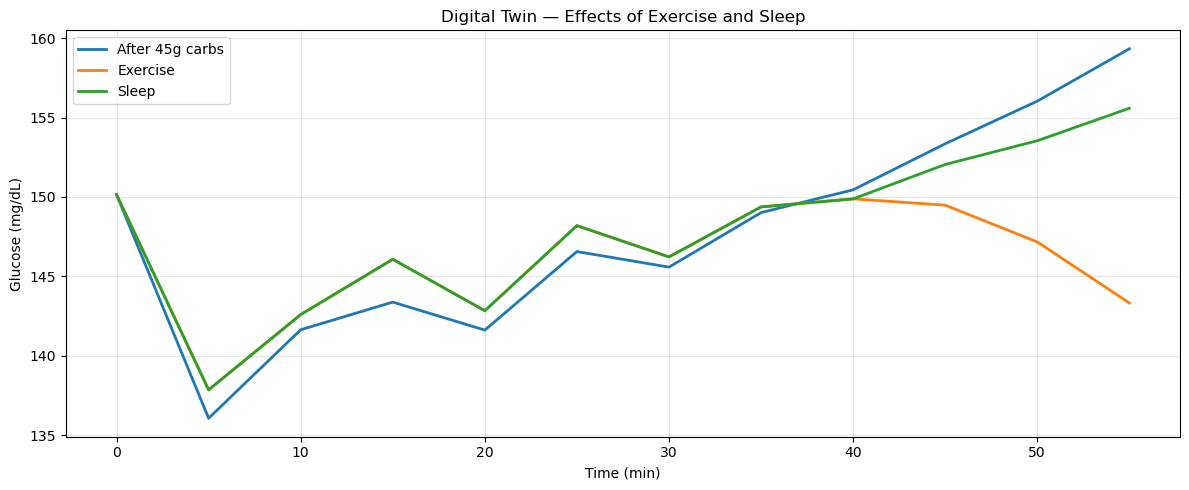

In [12]:
params = dict(
    steps=12,              
    dt_min=5,
    seq_len=36,
    CR_g_per_U=10.0,       
    ISF_mgdl_per_U=50.0,
    carb_peak_min=60, carb_total_min=180,
    ins_peak_min=75, ins_total_min=300,
)

#(a)(45g carbs)
df_base = simulate_with_exercise_sleep(
    model, scaler, df_now, feature_names,
    **params,
    meal_at_step=None, meal_grams=45,
    bolus_at_step=None, bolus_units=0,
    ex_at_step=None, ex_duration_steps=0, ex_intensity=0.0,
    sleep_at_step=None, sleep_duration_steps=0
)

#(b)Exercise only — 1h moderate at ~40 min
df_ex = simulate_with_exercise_sleep(
    model, scaler, df_now, feature_names,
    **params,
    meal_at_step=None, meal_grams=0,
    bolus_at_step=None, bolus_units=0,
    ex_at_step=8, ex_duration_steps=12, ex_intensity=0.7,  #starts at 40 min, lasts 60 min
    k_ex_drop_per_hr=55.0,               #mg/dL per hour at intensity=1.0
    ex_ISF_gain=0.25,                   
    ex_drop_peak_min=30, ex_drop_total_min=180,
    ex_sens_peak_min=90, ex_sens_total_min=360,
    sleep_at_step=None, sleep_duration_steps=0
)

#(c)Sleep only — 4h sleep starting at 60 min (binary mask)
df_sleep = simulate_with_exercise_sleep(
    model, scaler, df_now, feature_names,
    **params,
    meal_at_step=None, meal_grams=0,
    bolus_at_step=None, bolus_units=0,
    ex_at_step=None, ex_duration_steps=0, ex_intensity=0.0,
    sleep_at_step=12, sleep_duration_steps=48,
    k_sleep_drop_per_hr=8.0,
    sleep_ISF_gain=0.10,
    sleep_drop_peak_min=120, sleep_drop_total_min=480
)

t = np.arange(params["steps"]) * params["dt_min"]
plt.figure(figsize=(12,5))
plt.plot(t, baseline["glucose_pred"],  label="After 45g carbs", lw=2)
plt.plot(t, df_ex["glucose_pred"],    label="Exercise", lw=2)
plt.plot(t, df_sleep["glucose_pred"], label="Sleep", lw=2)
plt.xlabel("Time (min)"); plt.ylabel("Glucose (mg/dL)")
plt.title("Digital Twin — Effects of Exercise and Sleep")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


In [13]:
def generate_interventions(df_baseline, df_scenarios, scenario_labels, patient_name="Patient"):
    """
    df_baseline: baseline simulation dataframe
    df_scenarios: list of scenario dfs (e.g., meal, meal+insulin, exercise)
    scenario_labels: list of strings matching dfs
    """
    import numpy as np
    
    results = []
    base_final = df_baseline["glucose_pred"].iloc[-1]
    base_max   = df_baseline["glucose_pred"].max()

    for df, label in zip(df_scenarios, scenario_labels):
        final = df["glucose_pred"].iloc[-1]
        maxv  = df["glucose_pred"].max()

        delta_peak  = maxv - base_max
        delta_final = final - base_final

        if "Meal" in label and "Insulin" not in label:
            if delta_peak > 30:
                results.append(f"🔸 {label}: Peak glucose rises by {delta_peak:.1f} mg/dL vs baseline — consider a bolus or lighter meal.")
        elif "Meal" in label and "Insulin" in label:
            if delta_peak < 0:
                results.append(f"✅ {label}: Adequate control — insulin reduces meal spike by {abs(delta_peak):.1f} mg/dL.")
            else:
                results.append(f"⚠️ {label}: Partial correction — meal still elevates glucose by {delta_peak:.1f} mg/dL.")
        elif "Exercise" in label:
            if delta_final < -20:
                results.append(f"🏃 {label}: Glucose drops by {abs(delta_final):.1f} mg/dL. risk of mild Hypoglycemia(is a low blood sugar level), consider small carb intake before exercise")
            else:
                results.append(f"🏃 {label}: Exercise improves glucose stability by {abs(delta_final):.1f} mg/dL.")
        elif "Sleep" in label:
            if delta_final < -10:
                results.append(f"😴 {label}: Nighttime glucose decreases slightly ({abs(delta_final):.1f} mg/dL).")
            else:
                results.append(f"😴 {label}: Glucose stable during sleep.")
    
    text_report = f"Personalized Intervention Summary for {patient_name}:\n\n"
    text_report += "\n".join(results)
    return text_report


In [14]:
summary = generate_interventions(
    baseline,
    [meal45, meal45_bolus3, df_ex, df_sleep],
    ["Meal 45g", "Meal 45g + 3U", "Exercise", "Sleep"],
    patient_name="Patient"
)
print(summary)


Personalized Intervention Summary for Patient:

🔸 Meal 45g: Peak glucose rises by 128.5 mg/dL vs baseline — consider a bolus or lighter meal.
🔸 Meal 45g + 3U: Peak glucose rises by 45.8 mg/dL vs baseline — consider a bolus or lighter meal.
🏃 Exercise: Exercise improves glucose stability by 16.0 mg/dL.
😴 Sleep: Glucose stable during sleep.


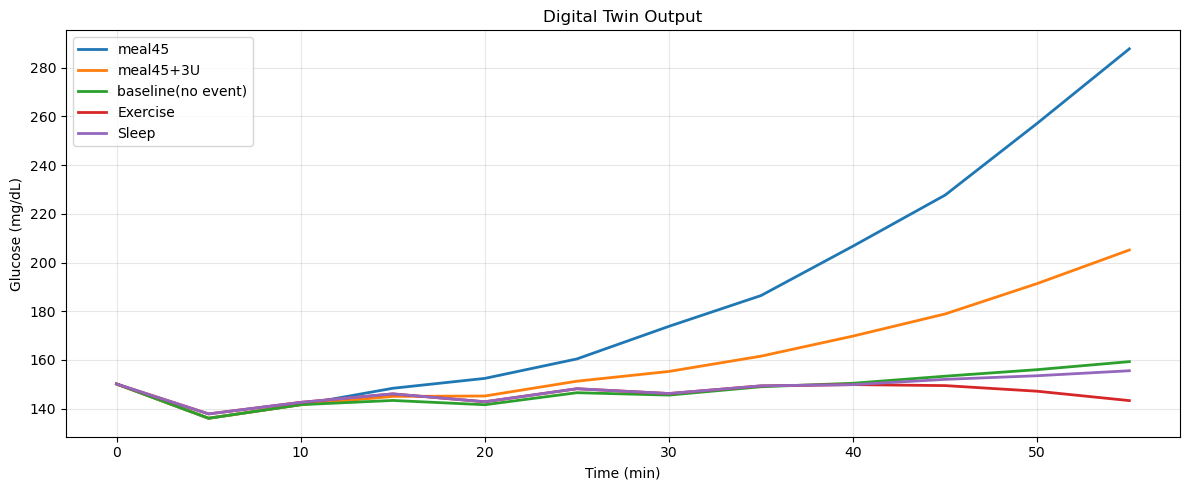

In [15]:
t = np.arange(params["steps"]) * params["dt_min"]
plt.figure(figsize=(12,5))
plt.plot(t, meal45["glucose_pred"],  label="meal45", lw=2)
plt.plot(t, meal45_bolus3["glucose_pred"],  label="meal45+3U", lw=2)
plt.plot(t, baseline["glucose_pred"],  label="baseline(no event)", lw=2)
plt.plot(t, df_ex["glucose_pred"],    label="Exercise", lw=2)
plt.plot(t, df_sleep["glucose_pred"], label="Sleep", lw=2)
plt.xlabel("Time (min)"); plt.ylabel("Glucose (mg/dL)")
plt.title("Digital Twin Output")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [16]:
import json
t = np.arange(params["steps"]) * params["dt_min"]

data = {
    "time_min": t.tolist(),
    "meal45": meal45["glucose_pred"].tolist(),
    "meal45_bolus3": meal45_bolus3["glucose_pred"].tolist(),
    "baseline": baseline["glucose_pred"].tolist(),
    "exercise": df_ex["glucose_pred"].tolist(),
    "sleep": df_sleep["glucose_pred"].tolist()
}

with open("digital_twin_output.json", "w") as f:
    json.dump(data, f, indent=4)

print("Data exported to digital_twin_output.json")

Data exported to digital_twin_output.json
